<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# High Dimensional & Deep Learning : Variational Autoencoders

## What is a Variational Autoencoder

A variational autoencoder is an autoencoder that learns a latent variable model for its input data.


TODO

## Objective

* Build a simple Variational Auto Encoder
* Use Variational Auto Encoder for Number Generation 
* Use Variational Auto Encoder To anomaly detection
* Write a Convolutional Variational Auto Encoder
* Use the Keras Model APi

## Library

In [1]:
from tensorflow.keras.datasets import mnist
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kloss
import tensorflow.keras.regularizers as kr
import tensorflow.keras.backend as K
import tensorflow.keras.utils as ku

import numpy as np
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

## Data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
input_dim = np.prod(x_train.shape[1:])
n_train = x_train.shape[0]
n_test = x_test.shape[0]
x_train = x_train.reshape((n_train, input_dim))
x_test = x_test.reshape((n_test, input_dim))

## Keras Model API

In the previous TP on image classification of the autoencoder notebook we have used the `Sequential` method to build model.

Sequential Method have limits when the architecture we want is not *linear* or when we want to build a layer on top on two different entries.

The `Model` API can sometimes be less intuitive but is much more flexible than the `Sequential` method. We will use it all along this TP.

## A simple Variational Autoencoders

### Param

In [3]:
# network parameters

batch_size=100
intermediate_dim = 512
latent_dim = 2
epochs = 50

### Encoder

#### Latent Variable

TODO add image here. <br>
TODO explain why log_var. <br>
We first build the encoder part. <br>
It is first composed of  a `Dense` layer with 512 neurons. <br>
Two `Dense` layer are then added on **top of the same layer**. These two layers will produce the two variable *z_mean* and  *z_log_var* in the latent space.

Note that we define each layer as a function of an input which is the output of the layer he follows.

In [4]:
# build encoder model
inputs = kl.Input(shape=(784,), name='encoder_input')
x = kl.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = kl.Dense(latent_dim, name='z_mean')(x)
z_log_var = kl.Dense(latent_dim, name='z_log_var')(x)

Instructions for updating:
Colocations handled automatically by placer.


#### The stochastic latent variable

We use the reparametrization trick to define a random variable z that is conditioned on the input image x as follows:

$$ z \sim \mathcal{N}(\mu_z(x), \sigma_z(x)) $$

<img src="image/vae_3.svg" width="600px" />



The reparametrization tricks defines $z$ has follows:

$$ z = \mu_z(x) + \sigma_z(x) \cdot \epsilon$$

with:

$$ \epsilon \sim \mathcal{N}(0, 1) $$

This way the dependency to between $z$ and $x$ is deterministic and differentiable. The randomness of $z$ only stems from $\epsilon$ only for a given $x$.

Note that in practice the output of the encoder network parameterizes $log(\sigma^2_z(x)$ instead of $\sigma_z(x)$. Taking the exponential of $log(\sigma^2_z(x)$ ensures the positivity of the standard deviation from the raw output of the network:

In [5]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = kl.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

So far we have defined all the layer we need to build the encoder part of the vae. <br> 
We now define the model, with the `Model`method. For that we just have to specify the input layer and the output we want (here, it's the latent variable z). The model is then build automatically.

TODO allow plot model

In [6]:
# instantiate encoder model

encoder = km.Model(inputs, z, name='encoder')
encoder.summary()
#ku.plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
z (Lambda)

### Decoder 

The decoder take as an input the a vector z (which is a sample of the latent distribution define by the encoder). 
it is then compose of 2 Dense layers with the following caracteristics : 

* 512 neurons, relu activation
* 784 neurons (input_shape), sigmoid activation

**Exercise** build this simple model using the Model API

In [7]:
# %load solutions/decoder_vae.py
# build decoder model
latent_inputs = kl.Input(shape=(latent_dim,), name='z_sampling')
x = kl.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = kl.Dense(784, activation='sigmoid')(x)

# instantiate decoder model
decoder = km.Model(latent_inputs, outputs, name='decoder')

In [8]:
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True) TODO


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


### Vae

We now associate the two model to define our Variational Autoencoder

In [9]:
# instantiate VAE model
outputs = decoder(encoder(inputs))
vae = km.Model(inputs, outputs, name='vae_mlp')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              (100, 2)                  403972    
_________________________________________________________________
decoder (Model)              multiple                  403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [10]:

reconstruction_loss = kloss.binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= 784
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [11]:
vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
60000/60000 [==============================] - 7s 123us/sample - loss: 189.4336 - val_loss: 168.2123
Epoch 2/50
60000/60000 [==============================] - 9s 147us/sample - loss: 165.3344 - val_loss: 163.2996
Epoch 3/50
60000/60000 [==============================] - 11s 176us/sample - loss: 161.7520 - val_loss: 160.7885
Epoch 4/50
60000/60000 [==============================] - 11s 190us/sample - loss: 159.4183 - val_loss: 158.9049
Epoch 5/50
60000/60000 [==============================] - 11s 188us/sample - loss: 157.5322 - val_loss: 157.1811
Epoch 6/50
60000/60000 [==============================] - 11s 187us/sample - loss: 155.8904 - val_loss: 155.8590
Epoch 7/50
60000/60000 [==============================] - 13s 212us/sample - loss: 154.4515 - val_loss: 154.3323
Epoch 8/50
60000/60000 [==============================] - 11s 188us/sample - loss: 153.3065 - val_loss: 153.3211


### Display images result

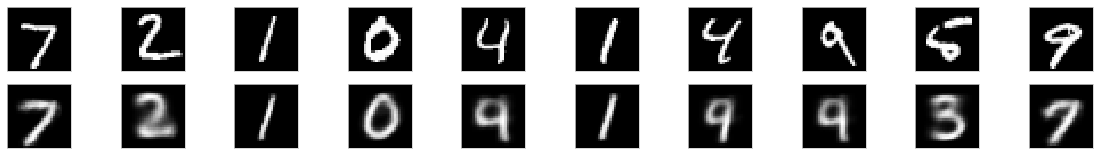

In [18]:
x_test_decoded_vae = vae.predict(x_test, batch_size= batch_size)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_decoded_vae[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Classification of latent variable

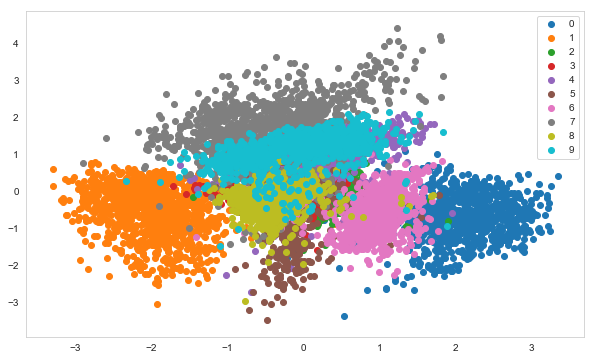

In [19]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1,1,1)
for i in range(10):
    x_test_encoded_i = x_test_encoded[y_test==i]
    plt.scatter(x_test_encoded_i[:, 0], x_test_encoded_i[:, 1], label=i)
ax.grid(False)
plt.legend()

plt.show()

## Generation of number

### Single Example

**Exercise** Generate a image number from two random latent varianle using the decoder

(-0.5, 27.5, 27.5, -0.5)

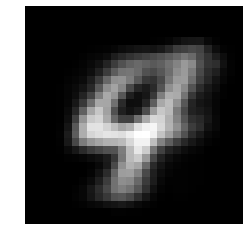

In [20]:
#%load solutions/generate_single_sample.py


random_z_from_prior = np.random.normal(size=(1, latent_dim))
generated = decoder.predict(random_z_from_prior)
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off')

### View of VAE Manifolds

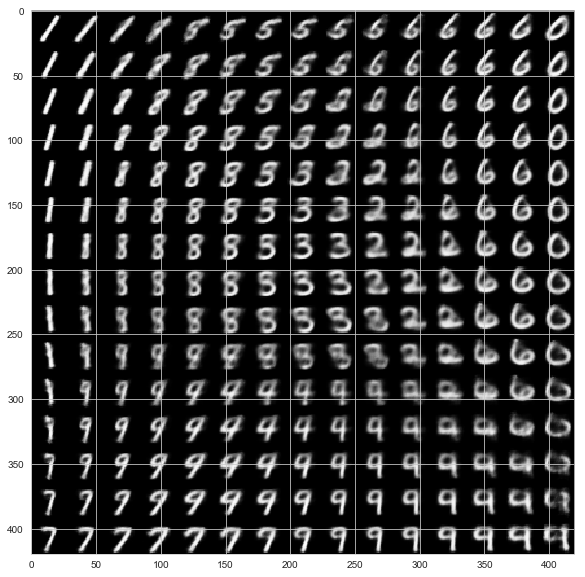

In [26]:

n = 15  # figure with 15x15 panels
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = sc.stats.norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = sc.stats.norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## Anomaly Detection

In this part we'll se how variational autoencoder can be used to anomaly detections

In [28]:
outlier_i = 9
x_train_normal = x_train[y_train!=outlier_i]
n_train = x_train_normal.shape[0]-x_train_normal.shape[0]%100
x_train_normal = x_train_normal[:n_train]
x_test_normal =  x_test[y_test!=outlier_i]
n_test = x_test_normal.shape[0]-x_test_normal.shape[0]%100
x_test_normal = x_test_normal[:n_test]

x_train_outliers = x_train[y_train==outlier_i]
n_train = x_train_outliers.shape[0]-x_train_outliers.shape[0]%100
x_train_outliers = x_train_outliers[:n_train]
x_test_outliers =  x_test[y_test==outlier_i]
n_test = x_test_outliers.shape[0]-x_test_outliers.shape[0]%100
x_test_outliers = x_test_outliers[:n_test]

x_train_normal.shape, x_train_outliers.shape, x_test_normal.shape, x_test_outliers.shape

((54000, 784), (5900, 784), (8900, 784), (1000, 784))

In [29]:
# encoder
inputs = kl.Input(shape=(784,), name='encoder_input')
x = kl.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = kl.Dense(latent_dim, name='z_mean')(x)
z_log_var = kl.Dense(latent_dim, name='z_log_var')(x)
z = kl.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder_ad = km.Model(inputs, z, name='encoder')

# decoder
latent_inputs = kl.Input(shape=(latent_dim,), name='z_sampling')
x = kl.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = kl.Dense(784, activation='sigmoid')(x)
decoder_ad = km.Model(latent_inputs, outputs, name='decoder')

# vae
outputs = decoder_ad(encoder_ad(inputs))
vae_ad = km.Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = kloss.binary_crossentropy(inputs,outputs)
reconstruction_loss *= 784
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_ad.add_loss(vae_loss)
vae_ad.compile(optimizer='adam')

vae_ad.fit(x_train_normal,epochs=epochs, batch_size=batch_size, validation_data=(x_test_normal, None))

Train on 54000 samples, validate on 8900 samples
Epoch 1/50
54000/54000 [==============================] - 12s 214us/sample - loss: 208.8187 - val_loss: 179.0522
Epoch 2/50
54000/54000 [==============================] - 11s 202us/sample - loss: 173.6768 - val_loss: 169.0275
Epoch 3/50
54000/54000 [==============================] - 10s 194us/sample - loss: 167.4106 - val_loss: 164.9380
Epoch 4/50
54000/54000 [==============================] - 11s 213us/sample - loss: 163.6081 - val_loss: 161.6256
Epoch 5/50
54000/54000 [==============================] - 12s 218us/sample - loss: 160.5308 - val_loss: 159.1555
Epoch 6/50
54000/54000 [==============================] - 11s 205us/sample - loss: 158.2872 - val_loss: 157.2995
Epoch 7/50
54000/54000 [==============================] - 12s 216us/sample - loss: 156.5618 - val_loss: 156.1997
Epoch 8/50
54000/54000 [==============================] - 11s 202us/sample - loss: 155.2312 - val_loss: 155.0661
Epoch 9/50
54000/54000 [=======================

### Display decoded image

#### Normal Dataset

In [30]:
x_test_decoded_vae = vae_ad.predict(x_test_normal, batch_size=batch_size)

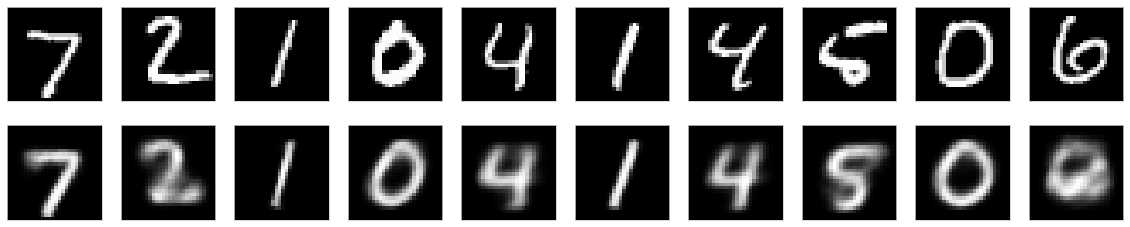

In [31]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_normal[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_decoded_vae[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Outlier Dataset

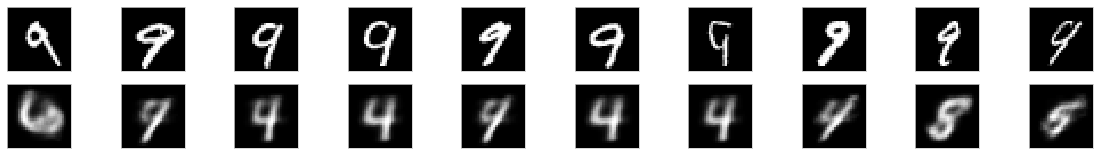

In [32]:
x_test_decoded_vae = vae_ad.predict(x_test_outliers, batch_size=batch_size)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_outliers[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_decoded_vae[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Question** : What can you say about the decoded images?

### Error Distribution

/anaconda3/envs/DL/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


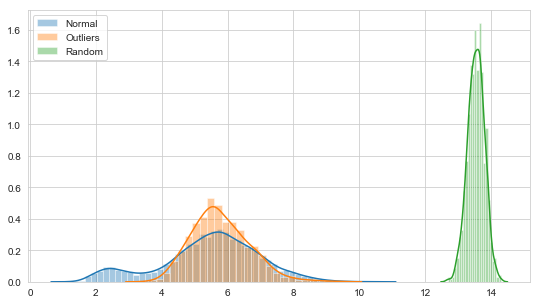

In [34]:
x_test_normal_decoded = vae_ad.predict(x_test_normal, batch_size=batch_size)
error_normal = np.linalg.norm(x_test_normal-x_test_normal_decoded, axis=1)

x_test_outliers_decoded = vae_ad.predict(x_test_outliers, batch_size =batch_size)
error_outliers = np.linalg.norm(x_test_outliers-x_test_outliers_decoded, axis=1)

x_random = np.random.uniform(size=(1000, 784),low=0.0, high=1.0)
x_random_decoded =  vae_ad.predict(x_random, batch_size=batch_size)
error_random = np.linalg.norm(x_random-x_random_decoded, axis=1)


fig=plt.figure(figsize=(9,5))
ax = fig.add_subplot(1,1,1)
sb.distplot(error_normal, ax=ax, label="Normal")
sb.distplot(error_outliers, ax=ax, label="Outliers")
sb.distplot(error_random , ax=ax, label="Random")

plt.legend()

## Convolutional Network

**Exercise** Write a convolutional variational autoencoder